In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.model_selection import train_test_split,KFold,cross_val_score,StratifiedKFold
from tensorflow.python.keras.models import Sequential,load_model
from tensorflow.python.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.python.keras.losses import MeanAbsoluteError
from tensorflow.python.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.layers import Activation, Dense,Flatten,LSTM,Dropout,LeakyReLU,BatchNormalization, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

In [3]:
df_train = pd.read_csv('training.csv', index_col = 1, parse_dates = True)
df_test = pd.read_csv('testing.csv', index_col = 1, parse_dates = True)

In [4]:
df_test=df_test.reset_index()
df_test["id"] = pd.to_numeric(df_test["id"], downcast="float")
df_test=df_test.set_index('id')

In [5]:
indices = list(range(4892866, 5755479))
for x in [5524547, 5524548, 5524549]:
    indices.remove(x)

In [6]:
missed = df_test.drop(index=indices)

In [7]:
import datetime
missed.time = missed.time + datetime.timedelta(0,60)

In [8]:
missed.reset_index(inplace = True)

In [9]:
missed['id'] = missed['id'].replace([5524547,5524548,5524549],5524550.5)

In [10]:
df_test_d=df_test.reset_index()
df_test_n = pd.concat([df_test_d,missed], axis=0)

In [11]:
df_test_n= df_test_n.set_index('id')

In [12]:
df_test_n = df_test_n.sort_index()

In [13]:
df_test = df_test_n.reset_index().set_index('time')

In [14]:
df_train = df_train.drop(["id"],axis=1)
df_test = df_test.drop(["id"],axis=1)
df_train.head(5)

,name,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,target
time,,,,,,,,,,,
2018-05-04 08:12:00+00:00,BTCUSDT,9727.90,9750.00,9727.90,9745.56,52.086680,507447.897326,454,39.258336,382501.194936,0.005881
2018-05-04 08:12:00+00:00,ETHUSDT,789.08,791.00,789.08,790.93,407.544770,322084.533567,379,303.069270,239530.381621,0.004171
2018-05-04 08:12:00+00:00,LTCUSDT,160.70,161.36,160.52,161.06,208.470510,33554.990241,76,193.770360,31190.987887,0.010191
2018-05-04 08:12:00+00:00,XRPUSDT,0.50,0.50,0.50,0.50,109.510000,54.755000,1,0.000000,0.000000,0.252573
2018-05-04 08:13:00+00:00,BTCUSDT,9745.56,9750.00,9727.93,9749.92,32.882566,320490.457569,486,21.424235,208845.957751,0.005537


In [15]:
def feature_adding (df):
  for i in df: 
    kwargs = {'Day_diff': lambda df1: (df1['Close']-df1['Open'])/df1['Open'],
              'Close_off_high': lambda x: 2*(x['High']- x['Close'])/(x['High']-x['Low'])-1,
              'Volatility': lambda x: (x['High']- x['Low'])/(x['Open'])
            }
    df = df.assign(**kwargs)
  return df

In [16]:
df_train = feature_adding(df_train)
df_test = feature_adding(df_test)

In [17]:
df_train = df_train.fillna(0)
df_test =df_test.fillna(0)

In [18]:
col_name="target"
first_col = df_train.pop(col_name)

In [19]:
df_train.insert(13, col_name, first_col)

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4892865 entries, 2018-05-04 08:12:00+00:00 to 2020-09-02 21:09:00+00:00
Data columns (total 14 columns):
name                            object
Open                            float64
High                            float64
Low                             float64
Close                           float64
Volume                          float64
Quote asset volume              float64
Number of trades                int64
Taker buy base asset volume     float64
Taker buy quote asset volume    float64
Day_diff                        float64
Close_off_high                  float64
Volatility                      float64
target                          float64
dtypes: float64(12), int64(1), object(1)
memory usage: 559.9+ MB


In [21]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 862616 entries, 2020-09-02 21:10:00+00:00 to 2021-01-30 21:10:00+00:00
Data columns (total 13 columns):
name                            862616 non-null object
Open                            862616 non-null float64
High                            862616 non-null float64
Low                             862616 non-null float64
Close                           862616 non-null float64
Volume                          862616 non-null float64
Quote asset volume              862616 non-null float64
Number of trades                862616 non-null int64
Taker buy base asset volume     862616 non-null float64
Taker buy quote asset volume    862616 non-null float64
Day_diff                        862616 non-null float64
Close_off_high                  862616 non-null float64
Volatility                      862616 non-null float64
dtypes: float64(11), int64(1), object(1)
memory usage: 92.1+ MB


In [22]:
df1= df_train.loc[df_train['name'] == "BTCUSDT"]
df2= df_train.loc[df_train['name'] == "ETHUSDT"]
df3= df_train.loc[df_train['name'] == "LTCUSDT"]
df4= df_train.loc[df_train['name'] == "XRPUSDT"]

In [23]:
column_types={'time','Open','High','Low','Close','Volume','Quote asset volume',
              'Number of trades','Taker buy base asset volume',
              'Taker buy quote asset volume'}

In [24]:
df1 = df1.reset_index().drop_duplicates(subset=column_types,keep='first').set_index('time')
df2 = df2.reset_index().drop_duplicates(subset=column_types,keep='first').set_index('time')
df3 = df3.reset_index().drop_duplicates(subset=column_types,keep='first').set_index('time')
df4 = df4.reset_index().drop_duplicates(subset=column_types,keep='first').set_index('time') 

In [25]:
df_BTC= df_test.loc[df_test['name'] == "BTCUSDT"]
df_ETH= df_test.loc[df_test['name'] == "ETHUSDT"]
df_LTC= df_test.loc[df_test['name'] == "LTCUSDT"]
df_XRP= df_test.loc[df_test['name'] == "XRPUSDT"]

In [26]:
df_BTC.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215654 entries, 2020-09-02 21:10:00+00:00 to 2021-01-30 21:10:00+00:00
Data columns (total 13 columns):
name                            215654 non-null object
Open                            215654 non-null float64
High                            215654 non-null float64
Low                             215654 non-null float64
Close                           215654 non-null float64
Volume                          215654 non-null float64
Quote asset volume              215654 non-null float64
Number of trades                215654 non-null int64
Taker buy base asset volume     215654 non-null float64
Taker buy quote asset volume    215654 non-null float64
Day_diff                        215654 non-null float64
Close_off_high                  215654 non-null float64
Volatility                      215654 non-null float64
dtypes: float64(11), int64(1), object(1)
memory usage: 23.0+ MB


In [27]:
rand_df1= df1.sample(frac=0.05, replace=False, random_state=1)
rand_df2= df2.sample(frac=0.05, replace=False, random_state=1)
rand_df3= df3.sample(frac=0.05, replace=False, random_state=1)
rand_df4= df4.sample(frac=0.05, replace=False, random_state=1)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/anaconda/envs/azureml_py3

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd7e9f22278>,
      dtype=object)

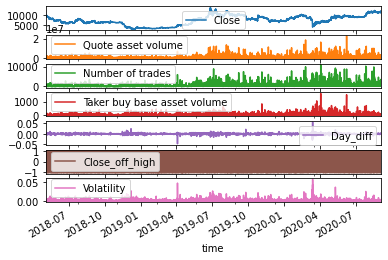

In [28]:
rand_df1[['Close','Quote asset volume','Number of trades','Taker buy base asset volume','Day_diff','Close_off_high','Volatility']].plot(subplots=True)

## MinMaxScaler

In [29]:
copy_df1 = rand_df1.drop(["name"],axis=1)
copy_df2 = rand_df2.drop(["name"],axis=1)
copy_df3 = rand_df3.drop(["name"],axis=1)
copy_df4 = rand_df4.drop(["name"],axis=1)

In [30]:
x_BTCUSDT=np.array(copy_df1.drop(["target"],axis=1))
x_ETHUSDT=np.array(copy_df2.drop(["target"],axis=1))
x_LTCUSDT=np.array(copy_df3.drop(["target"],axis=1))
x_XRPUSDT=np.array(copy_df4.drop(["target"],axis=1))

In [31]:
dataset_x = np.concatenate((x_BTCUSDT, x_ETHUSDT, x_LTCUSDT,x_XRPUSDT), axis = 1)

In [32]:
scaler=MinMaxScaler()
normalized_feature = scaler.fit_transform(dataset_x)

In [33]:
y_BTCUSDT=np.array(copy_df1[["target"]])
y_ETHUSDT=np.array(copy_df2[["target"]])
y_LTCUSDT=np.array(copy_df3[["target"]])
y_XRPUSDT=np.array(copy_df4[["target"]])

dataset_y = np.concatenate((y_BTCUSDT, y_ETHUSDT, y_LTCUSDT,y_XRPUSDT), axis = 1)

In [34]:
normalized_target = dataset_y.copy()

In [35]:
test_BTCUSDT=np.array(df_BTC.drop(["name"],axis=1))
test_ETHUSDT=np.array(df_ETH.drop(["name"],axis=1))
test_LTCUSDT=np.array(df_LTC.drop(["name"],axis=1))
test_XRPUSDT=np.array(df_XRP.drop(["name"],axis=1))

In [36]:
dataset_test = np.concatenate((test_BTCUSDT, test_ETHUSDT, test_LTCUSDT,test_XRPUSDT), axis = 1)
normalized_test = scaler.fit_transform(dataset_test)

In [56]:
look_arr = normalized_test[-60*12*5:]

In [57]:
normalized_test_n = np.concatenate((normalized_test, look_arr), axis=0)

## LTSM model (K-fold cross-validation) 

In [39]:
X_train, X_valid, Y_train, Y_valid = train_test_split(normalized_feature, normalized_target, test_size=0.3)

In [46]:
normalized_test_n.shape

(219254, 48)

In [59]:
look_back = 60*12*5
num_feature = 48
y_dummy = np.zeros(219254, )
train_generator = TimeseriesGenerator(X_train, Y_train,length=look_back,sampling_rate=1,stride=1, batch_size=32)
valid_generator = TimeseriesGenerator(X_valid, Y_valid,length=look_back,sampling_rate=1,stride=1, batch_size=32)
test_generator = TimeseriesGenerator(normalized_test_n, y_dummy,length=look_back,sampling_rate=1,stride=1, batch_size=32)

In [44]:
with tf.device('/GPU:0'):
    model = Sequential()
    model.add(CuDNNLSTM(128,recurrent_initializer='orthogonal',input_shape=(look_back, num_feature),return_sequences=True))
    model.add(LeakyReLU(alpha=0.25))
    model.add(CuDNNLSTM(128,return_sequences=True))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.2))
    model.add(CuDNNLSTM(128,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(4))

In [48]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
checkpointer = ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
model.compile(loss='mean_squared_error', optimizer='adam', weighted_metrics = [MeanAbsoluteError()] ) 

In [49]:
model.fit_generator(train_generator, validation_data = valid_generator,epochs=10,callbacks = [checkpointer])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1226 steps, validate for 461 steps
Epoch 1/10
1226/1226 [==============================] - 1828s 1s/step - loss: 1.8307e-05 - mean_absolute_error: 0.0023 - val_loss: 1.3579e-05 - val_mean_absolute_error: 0.0019
Epoch 2/10
1226/1226 [==============================] - 1802s 1s/step - loss: 1.1794e-05 - mean_absolute_error: 0.0021 - val_loss: 1.4256e-05 - val_mean_absolute_error: 0.0021
Epoch 3/10
1226/1226 [==============================] - 1802s 1s/step - loss: 1.1613e-05 - mean_absolute_error: 0.0021 - val_loss: 1.3839e-05 - val_mean_absolute_error: 0.0019
Epoch 4/10
1226/1226 [==============================] - 1802s 1s/step - loss: 1.1311e-05 - mean_absolute_error: 0.0020 - val_loss: 1.3528e-05 - val_mean_absolute_error: 0.0019
Epoch 5/10
1226/1226 [==============================] - 1802s 1s/step - loss: 1.1056e-05 - mean_absolute_error: 0.0019 - val_

In [74]:
model.save('my_model_v2.h5') 

## Submission

In [61]:
prediction = model.predict(test_generator)

In [62]:
prediction.shape

(215654, 4)

In [88]:
submit_arr= np.reshape(prediction, (np.product(prediction.shape),))

In [89]:
submit_arr.shape

(862616,)

In [85]:
submit_arr = np.argmax(submit_arr)

In [90]:
len(np.arange(4892866,5755482))

862616

In [91]:
 d = { "id":np.arange(4892866,5755482), "Predicted": submit_arr}

submit_df = pd.DataFrame(data=d )

In [92]:
submit_df.head()

,id,Predicted
0,4892866,0.000079
1,4892867,0.000283
2,4892868,0.000931
3,4892869,0.000246
4,4892870,0.000078


In [68]:
submit_df.set_index('id', inplace=True)
extra = [5524547, 5524548, 5524549]
final_df = submit_df.drop(index=extra)

In [82]:
result = pd.DataFrame({'Id':np.arange(4892866,5755479), 'Predicted':final_df["Predicted"]},columns=['Id','Predicted'])

In [83]:
result.head()

,Id,Predicted
id,,
4892866,4892866,0.000079
4892867,4892867,0.000283
4892868,4892868,0.000931
4892869,4892869,0.000246
4892870,4892870,0.000078


In [84]:
result.set_index('Id', inplace=True)
result.to_csv('Result.csv',index=True)